# Model Evaluation

During this week we will use the dataset called Adult from UCI Machine Learning Repository, the dataset is described [here](https://archive.ics.uci.edu/dataset/2/adult). Please read the dataset's description.

## Agenda
- Cross validation
- Regularization
- Hyperparameter search
- More classification metrics
- Missing value imputation


In [1]:
import urllib.request
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Preparing the data

The dataset can only be downloaded as a zip file. Let's download, unzip, and open it.


In [2]:
url = "https://archive.ics.uci.edu/static/public/2/adult.zip"
urllib.request.urlretrieve(url, "adult.zip")

with zipfile.ZipFile("adult.zip", "r") as zip_ref:
    zip_ref.extractall("adults")

columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# the dataset is pre-split into train and test
# I want to do the split myself, so let's join the datasets
df1 = pd.read_csv("adult.data", header=None, names=columns)
# first row of adult.test is weird, let's remove it
df2 = pd.read_csv("adult.test", header=None, names=columns)[1:]
df = pd.concat([df1, df2])

In [3]:
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
2218,48,Private,310639.0,Some-college,10.0,Divorced,Exec-managerial,Not-in-family,White,Male,0.0,0.0,50.0,United-States,<=50K.
6012,39,Private,116477.0,Assoc-voc,11.0,Divorced,Tech-support,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K.
21298,25,Private,232914.0,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0.0,0.0,38.0,United-States,<=50K
29704,24,Private,224954.0,Some-college,10.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
7378,73,Private,132350.0,7th-8th,4.0,Widowed,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,18.0,United-States,<=50K.


There's one column with a mysterious and undocumented column `fnlwgt`, let's drop it.

In [4]:
df = df.drop(columns=["fnlwgt"])

Some columns have dashes (-) instead of underscores in their names. I don't like that, so I'll rename the columns to use underscores.

In [5]:
df = df.rename(columns=lambda x: x.replace("-", "_"))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  object 
 1   workclass       48842 non-null  object 
 2   education       48842 non-null  object 
 3   education_num   48842 non-null  float64
 4   marital_status  48842 non-null  object 
 5   occupation      48842 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   capital_gain    48842 non-null  float64
 10  capital_loss    48842 non-null  float64
 11  hours_per_week  48842 non-null  float64
 12  native_country  48842 non-null  object 
 13  income          48842 non-null  object 
dtypes: float64(4), object(10)
memory usage: 5.6+ MB


There are no null values in the columns, but from the column description [here](https://archive.ics.uci.edu/dataset/2/adult) I see that some of them have missing values. Maybe the missing values are encoded differently? 

In [7]:
df.sample(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1337,40,Private,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
2913,59,Private,Assoc-voc,11.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45.0,United-States,>50K.
9683,24,Private,HS-grad,9.0,Never-married,Tech-support,Not-in-family,White,Male,0.0,0.0,45.0,United-States,<=50K.
15587,61,Private,9th,5.0,Widowed,Other-service,Unmarried,Black,Female,0.0,0.0,40.0,United-States,<=50K.
23475,48,Private,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K
7430,21,Private,Some-college,10.0,Never-married,Sales,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K.
19317,45,Private,Bachelors,13.0,Never-married,Prof-specialty,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3222,34,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Male,0.0,0.0,60.0,?,>50K.
13739,43,Private,Bachelors,13.0,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,0.0,2258.0,50.0,United-States,>50K.
16627,37,Self-emp-not-inc,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,Cuba,>50K


Indeed, "?" seems to represent a missing value. In fact, it's " ?" (with a space).

In [8]:
# Replace "?" with NaN in all columns
df = df.replace(" ?", pd.NA)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  object 
 1   workclass       46043 non-null  object 
 2   education       48842 non-null  object 
 3   education_num   48842 non-null  float64
 4   marital_status  48842 non-null  object 
 5   occupation      46033 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   capital_gain    48842 non-null  float64
 10  capital_loss    48842 non-null  float64
 11  hours_per_week  48842 non-null  float64
 12  native_country  47985 non-null  object 
 13  income          48842 non-null  object 
dtypes: float64(4), object(10)
memory usage: 5.6+ MB


In [10]:
df["income"].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [11]:
# map target to more usable 0/1
df["income"] = df["income"].str.strip().str.replace(".", "")
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})

# Convert age column to integer type
df["age"] = df["age"].astype(int)

In [12]:
df["sex"].value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

In [13]:
df["sex"] = df["sex"].map({" Male": 1, " Female": 0})

The dataset is now ready for analysis and modelling!

In [14]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)


## 1. EDA and plotting



In [15]:
df_train["income"].value_counts()

income
0    29772
1     9301
Name: count, dtype: int64

There is some inbalance in our labels, but it is not very severe.


Let's inspect the relationship between continuous variables and the target.


<Axes: xlabel='capital_gain', ylabel='Density'>

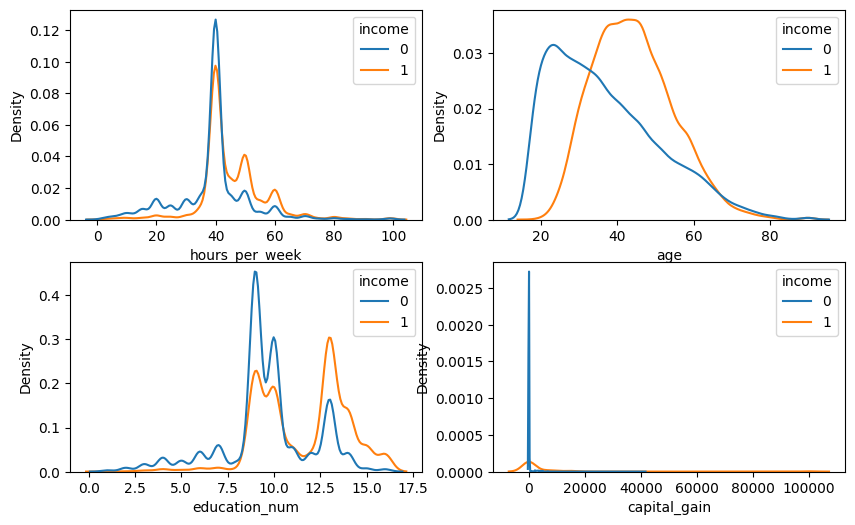

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
sns.kdeplot(x="hours_per_week", hue="income", data=df_train, ax=axs[0, 0], common_norm=False)
sns.kdeplot(x="age", hue="income", data=df_train, ax=axs[0, 1], common_norm=False)
sns.kdeplot(x="education_num", hue="income", data=df_train, ax=axs[1, 0], common_norm=False)
sns.kdeplot(x="capital_gain", hue="income", data=df_train, ax=axs[1, 1], common_norm=False)

For the capital gain variable it seems that for most survey participants the value is 0.

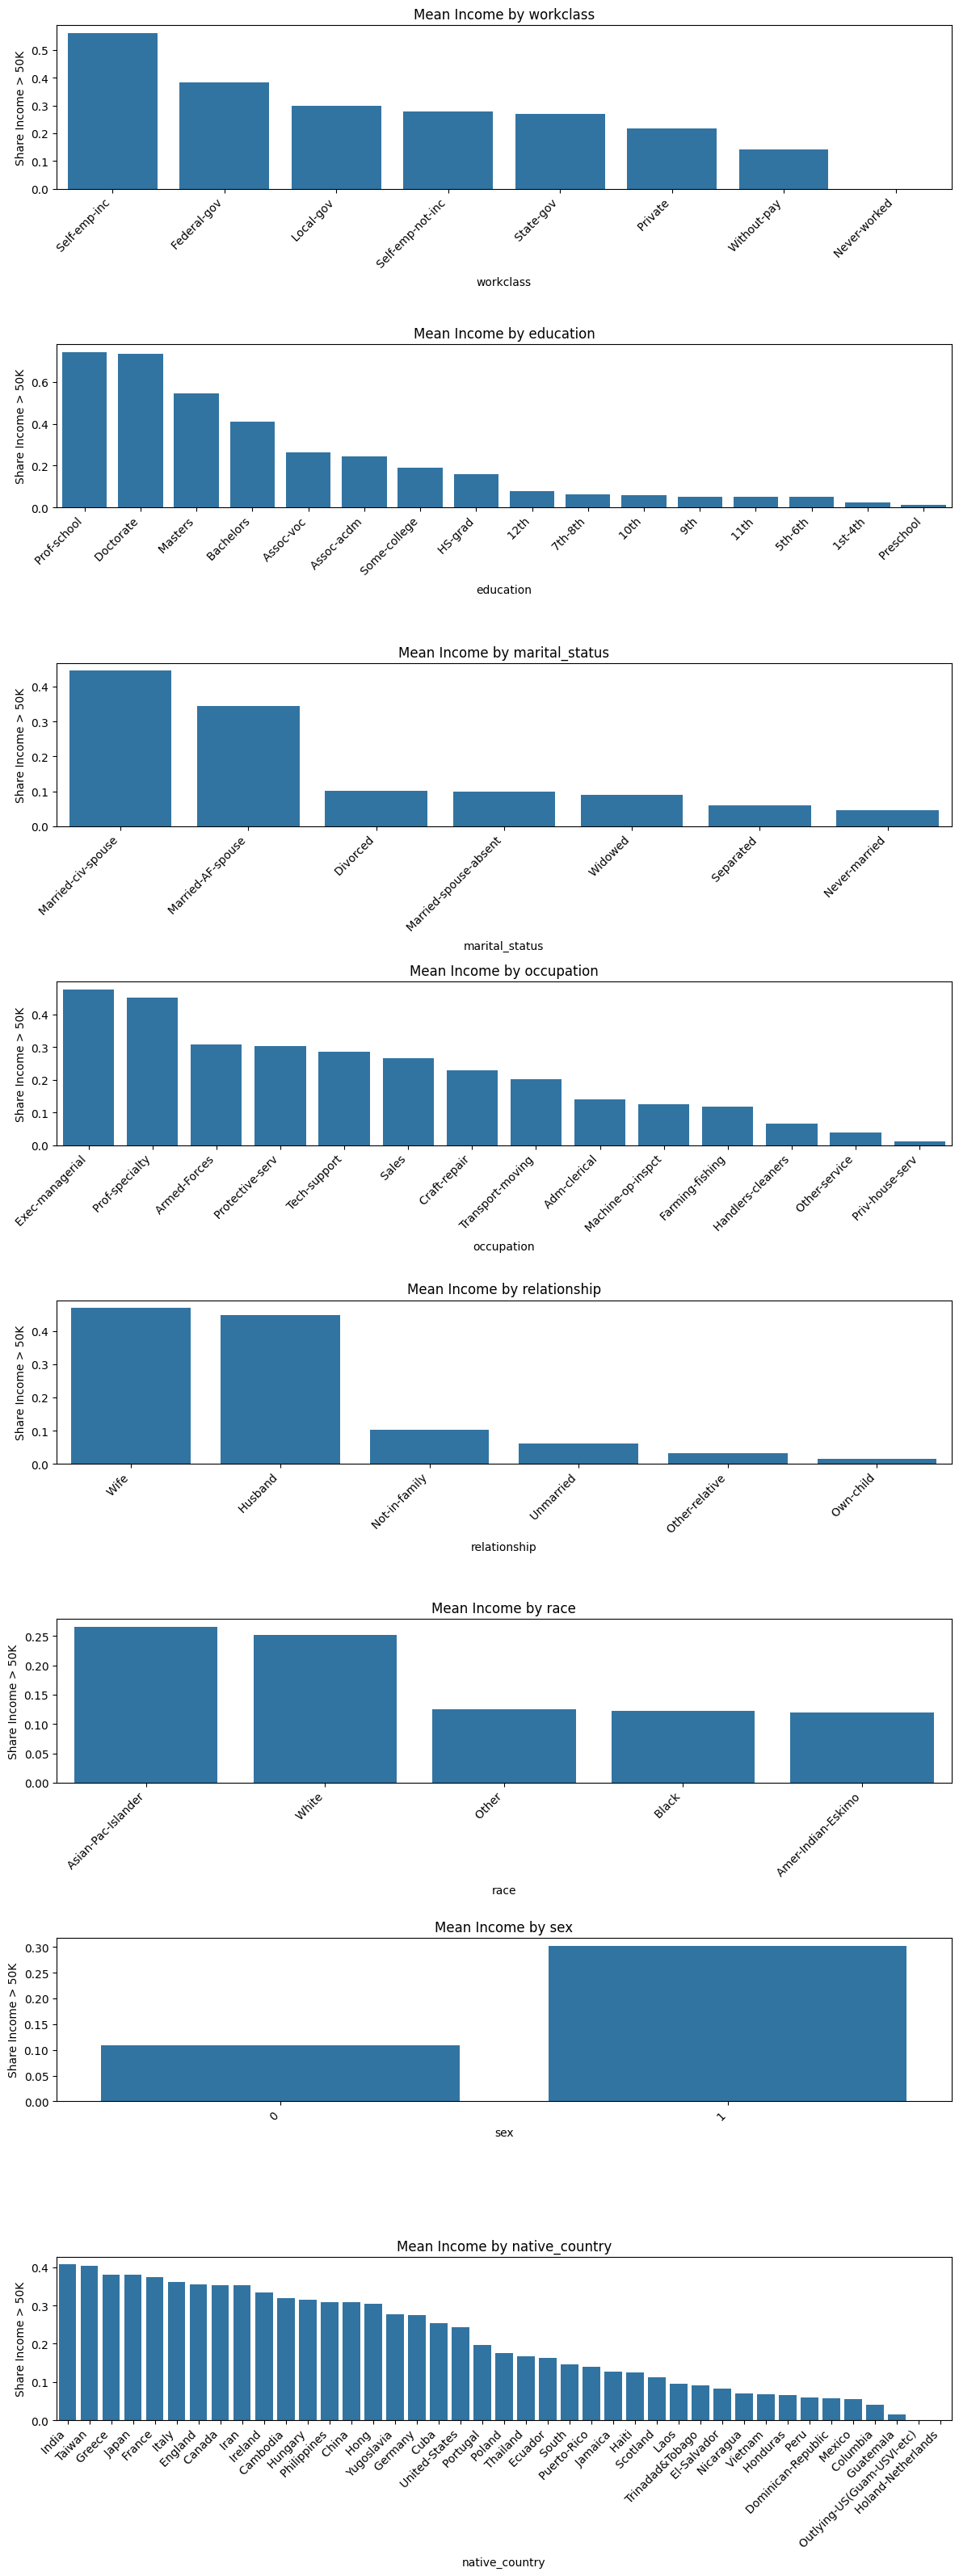

In [17]:
categorical_cols = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native_country",
]

fig, axs = plt.subplots(
    len(categorical_cols), 1, figsize=(12, 4 * len(categorical_cols))
)

for i, col in enumerate(categorical_cols):
    mean_income = df_train.groupby(col)["income"].mean().sort_values(ascending=False)
    sns.barplot(x=mean_income.index, y=mean_income.values, ax=axs[i])
    axs[i].set_title(f"Mean Income by {col}")
    axs[i].set_ylabel("Share Income > 50K")
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

That's enough plotting for now. It seems that most variables in the dataset are correlated with the target variable.